# CASA I/O: Intro tutorial for extracting data from MS

This tutorial describes the simplest, most flexible way to extract data from measurement sets into Python memory/numpy files. To follow this tutorial, you will need to have installed casatools, casatasks, as well as have downloaded and calibrated a measurement set.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

import casatools
from casatasks import listobs  # uvcontsub, cvel (optional; shown later)

from astropy.constants import c

### Step 0: Inspect your measurement set (note spectral windows (spws), numbers of channels, etc)

In [3]:
ms_path = "/home/darthbarth/Big_red/NGC4697/ngc4697_high_res/NGC4697_bary_10kms.ms.split.cal.contsub"  #path to your measurement set
assert os.path.exists(ms_path), f"MS not found: {ms_path}"

In [4]:
# Write listobs to a text file so you can quickly inspect SPWs/fields/scans
listobs_out = "listobs.txt"
listobs(vis=ms_path, listfile=listobs_out, overwrite=True)
print(f"Wrote: {listobs_out}")

Wrote: listobs.txt


In [5]:
# Quick SPW / datadesc overview
msmd = casatools.msmetadata()
msmd.open(ms_path)

ddids = msmd.datadescids()
print("Available DATA_DESC_IDs:", ddids)

# Map ddid -> spw id
for ddid in ddids:
    spw_id = msmd.spwfordatadesc(ddid)
    nchan  = msmd.nchan(spw_id)
    print(f"ddid={ddid:>3} -> spw={spw_id:>3} with nchan={nchan}")

msmd.done()

Available DATA_DESC_IDs: [0 1]
ddid=  0 -> spw=  0 with nchan=80
ddid=  1 -> spw=  1 with nchan=80


True

### Step 1: Select your SPW and load the relevant columns into memory 
In this example, we load the columns labeled `antenna1`, `antenna2`, `uvw`, `flag`, `flag_row`, `weight`, and `data` from `SPW 0`.

For combining observations with multiple SPWs, see the tutorial [here](https://viscube.readthedocs.io/en/latest/notebooks/combining_low_high_res_casa.html) instead.

In [6]:
datadescid = 0  # <-- set this to the ddid you want (single SPW setup)
data_column = "DATA"  # or "CORRECTED_DATA", this part depends on the preprocessing pipeline you used

In [7]:
ms = casatools.ms()
ms.open(ms_path)

ms.selectinit(datadescid=int(datadescid))

# Read just what we need
query = ms.getdata([
    "UVW", "ANTENNA1", "ANTENNA2",
    "WEIGHT", "FLAG", "FLAG_ROW",
    "AXIS_INFO",
    data_column
])

ant1 = query["antenna1"]          # (nrow,)
ant2 = query["antenna2"]          # (nrow,)
uvw_m = query["uvw"]              # (3, nrow) in meters
flag = query["flag"]              # (npol, nchan, nrow) boolean
flag_row = query["flag_row"]      # (nrow,) boolean
weight = query["weight"]          # often (npol, nrow) but sometimes other shapes

# DATA key may come back lowercased depending on CASA version
if data_column.lower() in query:
    data = query[data_column.lower()]   # (npol, nchan, nrow) complex
else:
    data = query[data_column]

info = query["axis_info"]
chan_freq_hz = info["freq_axis"]["chan_freq"].flatten()  # (nchan,)

# Reset selection + close
ms.selectinit(reset=True)
ms.close()

print("Raw shapes:")
print("  data:", data.shape)
print("  flag:", flag.shape)
print("  uvw_m:", uvw_m.shape)
print("  weight:", np.asarray(weight).shape)
print("  chan_freq_hz:", chan_freq_hz.shape)

Raw shapes:
  data: (2, 80, 81795)
  flag: (2, 80, 81795)
  uvw_m: (3, 81795)
  weight: (2, 81795)
  chan_freq_hz: (80,)


### Step 2: Regularize the shape of the WEIGHT column

CASA sometimes returns WEIGHT as (nrow,) or (1, nrow). We standardize it so later broadcasting works cleanly.

In [8]:
weight = np.asarray(weight)
npol, nchan, nrow = flag.shape

if weight.ndim == 1:
    # treat as per-row weights, replicate for each polarization
    assert weight.shape[0] == nrow
    weight = np.tile(weight[None, :], (npol, 1))

elif weight.ndim == 2:
    assert weight.shape[1] == nrow
    if weight.shape[0] == 1 and npol > 1:
        weight = np.tile(weight, (npol, 1))

else:
    raise ValueError(f"Unexpected WEIGHT shape: {weight.shape}")

print("Normalized weight shape:", weight.shape)  # (npol, nrow)


Normalized weight shape: (2, 81795)


### Step 3: Flag data using FLAG_ROW

Apply FLAG_ROW to every polarization and channel

In [9]:
flag = np.logical_or(flag, flag_row[None, None, :])
print("Flagged fraction (including FLAG_ROW):", float(flag.mean()))

Flagged fraction (including FLAG_ROW): 0.09407665505226481


### Step 4: Remove autocorrelations

In [10]:
xc = np.where(ant1 != ant2)[0]

data = data[:, :, xc]
flag = flag[:, :, xc]
uvw_m = uvw_m[:, xc]
weight = weight[:, xc]

print("After autocorr removal:")
print("  data:", data.shape)
print("  flag:", flag.shape)
print("  uvw_m:", uvw_m.shape)
print("  weight:", weight.shape)

After autocorr removal:
  data: (2, 80, 77900)
  flag: (2, 80, 77900)
  uvw_m: (3, 77900)
  weight: (2, 77900)


### Step 5: Average polarizations (weighted), reshape flag to match

In [11]:
# Broadcast weight to match (npol, nchan, nvis)
w_b = weight[:, None, :]                  # (npol, 1, nvis)
wsum = np.sum(w_b, axis=0)                # (nchan, nvis)
wsum_safe = np.where(wsum > 0, wsum, 1.0)

data = np.sum(data * w_b, axis=0) / wsum_safe   # (nchan, nvis)
flag = np.any(flag, axis=0)                     # (nchan, nvis)
weight_row = np.sum(weight, axis=0)             # (nvis,)

print("After pol-avg:")
print("  data:", data.shape)
print("  flag:", flag.shape)
print("  weight_row:", weight_row.shape)

After pol-avg:
  data: (80, 77900)
  flag: (80, 77900)
  weight_row: (77900,)


### Step 6: Build flagged data mask

In [12]:
mask = ~flag  # (nchan, nvis)
print("Valid fraction:", float(mask.mean()))

Valid fraction: 0.9512195121951219


### Step 7: Convert UVW from meters to lambda

In [13]:
u_m, v_m, w_m = uvw_m
nu = chan_freq_hz[:, None]  # (nchan, 1)

u_lam = (u_m[None, :] * nu / c.value)  # (nchan, nvis)
v_lam = (v_m[None, :] * nu / c.value)  # (nchan, nvis)
w_lam = (w_m[None, :] * nu / c.value)  # (nchan, nvis)

print("u_lam/v_lam/w_lam:", u_lam.shape, v_lam.shape, w_lam.shape)

u_lam/v_lam/w_lam: (80, 77900) (80, 77900) (80, 77900)


### Step 8: Ensure frequencies are increasing

##### If working with continuum data, skip down to Step 8 (alternative for continuum data) instead!

In [14]:
is_increasing = np.all(np.diff(chan_freq_hz) > 0)
print("Frequency increasing?", is_increasing)

if not is_increasing:
    chan_freq_cube_hz = chan_freq_hz[::-1].copy()
    data_cube = data[::-1].copy()
    mask_cube = mask[::-1].copy()
    u_cube = u_lam[::-1].copy()
    v_cube = v_lam[::-1].copy()
    w_cube = w_lam[::-1].copy()
else:
    chan_freq_cube_hz = chan_freq_hz.copy()
    data_cube = data.copy()
    mask_cube = mask.copy()
    u_cube = u_lam.copy()
    v_cube = v_lam.copy()
    w_cube = w_lam.copy()

# weights as cube-shaped array (handy later; still no gridding here)
weight_cube = np.tile(weight_row[None, :], (data_cube.shape[0], 1)).astype(float)

print("Cube shapes:")
print("  data_cube:", data_cube.shape)
print("  mask_cube:", mask_cube.shape)
print("  u_cube:", u_cube.shape)
print("  weight_cube:", weight_cube.shape)

Frequency increasing? False
Cube shapes:
  data_cube: (80, 77900)
  mask_cube: (80, 77900)
  u_cube: (80, 77900)
  weight_cube: (80, 77900)


### Step 9: Inspect data and save

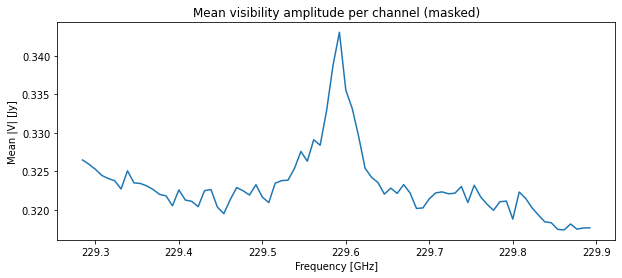

In [15]:
amp_mean = np.nanmean(np.where(mask_cube, np.abs(data_cube), np.nan), axis=1)

plt.figure(figsize=(10, 4))
plt.plot(chan_freq_cube_hz/1e9, amp_mean)
plt.xlabel("Frequency [GHz]")
plt.ylabel("Mean |V| [Jy]")
plt.title("Mean visibility amplitude per channel (masked)")
plt.show()

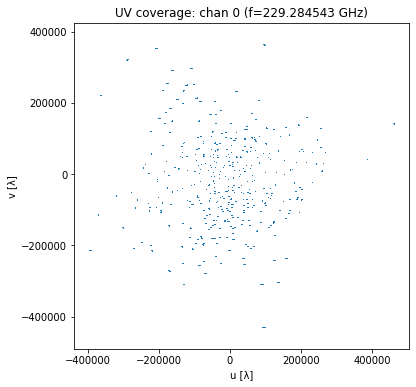

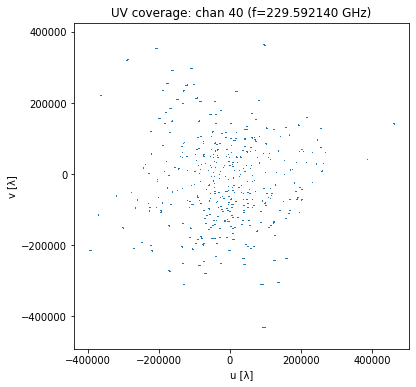

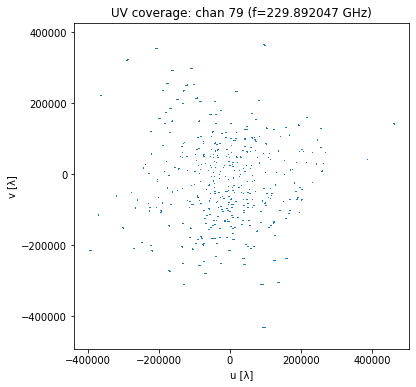

In [18]:
# UV coverage snapshots for a few channels
for k in [0, data_cube.shape[0]//2, data_cube.shape[0]-1]:
    valid_k = mask_cube[k]
    plt.figure(figsize=(6, 6))
    plt.scatter(u_cube[k, valid_k][::2], v_cube[k, valid_k][::2], s=1, linewidths=0)
    plt.xlabel("u [λ]"); plt.ylabel("v [λ]")
    plt.title(f"UV coverage: chan {k} (f={chan_freq_cube_hz[k]/1e9:.6f} GHz)")
    plt.axis("equal")
    plt.show()

In [ ]:
np.savez(
     "cube_extracted.npz",
     chan_freq_hz=chan_freq_cube_hz,
     u=u_cube, v=v_cube, w=w_cube,
     vis=data_cube,
     weight=weight_cube,
     mask=mask_cube,
)

########################################################################################################

### Step 8 (alternative for continuum data): Channel averaging and flattening across frequency

In [19]:
n_avg = 8  # fixed per your preference

nchan = data.shape[0]
n_new = (nchan // n_avg) * n_avg
print("nchan -> n_new:", nchan, "->", n_new)

# truncate to a multiple of n_avg
data_tr = data[:n_new]
u_tr = u_lam[:n_new]
v_tr = v_lam[:n_new]
w_tr = w_lam[:n_new]
mask_tr = mask[:n_new]
freq_tr = chan_freq_hz[:n_new]

# reshape (n_new/n_avg, n_avg, nvis) then average over the chunk axis
data_avg = data_tr.reshape(n_new // n_avg, n_avg, -1).mean(axis=1)
u_avg = u_tr.reshape(n_new // n_avg, n_avg, -1).mean(axis=1)
v_avg = v_tr.reshape(n_new // n_avg, n_avg, -1).mean(axis=1)
w_avg = w_tr.reshape(n_new // n_avg, n_avg, -1).mean(axis=1)

# mask: majority vote within chunk
mask_avg = mask_tr.astype(float).reshape(n_new // n_avg, n_avg, -1).mean(axis=1) > 0.5

# averaged channel frequencies
chan_freq_avg_hz = freq_tr.reshape(n_new // n_avg, n_avg).mean(axis=1)

print("Averaged shapes:")
print("  data_avg:", data_avg.shape)
print("  mask_avg:", mask_avg.shape)
print("  chan_freq_avg_hz:", chan_freq_avg_hz.shape)

nchan -> n_new: 80 -> 80
Averaged shapes:
  data_avg: (10, 77900)
  mask_avg: (10, 77900)
  chan_freq_avg_hz: (10,)


In [20]:
valid = mask_avg  # (nchan_avg, nvis)

u_cont = u_avg[valid]
v_cont = v_avg[valid]
w_cont = w_avg[valid]
vis_cont = data_avg[valid]

# broadcast weights to (nchan_avg, nvis), then apply mask+flatten
weight_chan = np.tile(weight_row[None, :], (data_avg.shape[0], 1))
wt_cont = weight_chan[valid].astype(float)

print("Continuum vectors:")
print("  u_cont:", u_cont.shape)
print("  v_cont:", v_cont.shape)
print("  w_cont:", w_cont.shape)
print("  vis_cont:", vis_cont.shape)
print("  wt_cont:", wt_cont.shape)

Continuum vectors:
  u_cont: (741000,)
  v_cont: (741000,)
  w_cont: (741000,)
  vis_cont: (741000,)
  wt_cont: (741000,)


### Step 9 (alternative for continuum data): Inspect data and save

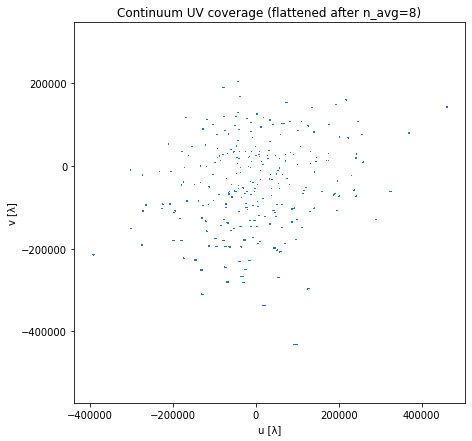

In [21]:
# UV coverage
step = max(1, u_cont.size // 200000)
plt.figure(figsize=(7, 7))
plt.scatter(u_cont[::step], v_cont[::step], s=1, linewidths=0)
plt.xlabel("u [λ]")
plt.ylabel("v [λ]")
plt.title("Continuum UV coverage (flattened after n_avg=8)")
plt.axis("equal")
plt.show()

In [ ]:
np.savez(
     "continuum_extracted_navg8.npz",
     u=u_cont, v=v_cont, w=w_cont,
     vis=vis_cont, weight=wt_cont,
     chan_freq_avg_hz=chan_freq_avg_hz,
)